In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import copy
from football_sim.all import Calibrator, Season,Settings
%matplotlib inline

In [2]:
base_dir = './'

settings = Settings(os.path.join(base_dir, 'config.yaml'))

In [3]:
settings.domestic_leagues.append('ELC')
settings.league_info['ELC']={'nr_cl': 2, 'nr_deg': 3}

In [4]:
calib = Calibrator(settings)
calib.download_all_data() 
calib.process_data()

In [5]:
year = 2019
league = 'BPL'
calib.calibrate_teams(league,year)

In [6]:
season = Season(league, year,calib, use_home_advantage=False)
print('home advantage', season.home_advantage)

season.process_current_results()
season.simulate_season(n_scenarios=100000)
season.process_simulation()

home advantage 1


In [7]:
#i=season.match_id['bpl_sheffieldunited_chelsea_2020-07-11']
#hg=season.simulated_home_goals[i,:]
#ag=season.simulated_away_goals[i,:]
#ind = ag<hg
ind = None
sr=season.season_report(ind=ind)
sr

,Played,Points (current),Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,rating,Degr
Liverpool,35,93,99.2,96,102,1,1,100.0,100.00,5.88,0.26,22.556342,0.00
Manchester City,35,72,80.0,77,81,2,2,0.0,100.00,7.29,0.19,39.425741,0.00
Manchester United,34,58,66.3,62,70,5,3,0.0,86.28,5.16,0.22,23.711866,0.00
Chelsea,35,60,64.6,61,69,6,3,0.0,68.34,5.12,0.33,15.522606,0.00
Leicester City,35,59,62.9,59,66,7,3,0.0,38.33,4.21,0.32,13.354079,0.00
Wolverhampton,35,55,60.2,56,64,8,4,0.0,6.48,3.53,0.21,16.840441,0.00
Sheffield United,35,54,58.0,54,61,9,5,0.0,0.48,3.34,0.30,11.065818,0.00
Tottenham Hotspur,35,52,56.9,53,61,10,6,0.0,0.09,3.89,0.33,11.646975,0.00
Arsenal,35,50,54.3,51,59,11,7,0.0,0.00,4.08,0.31,13.002199,0.00
Burnley,35,50,54.0,51,57,11,8,0.0,0.00,2.99,0.36,8.402844,0.00


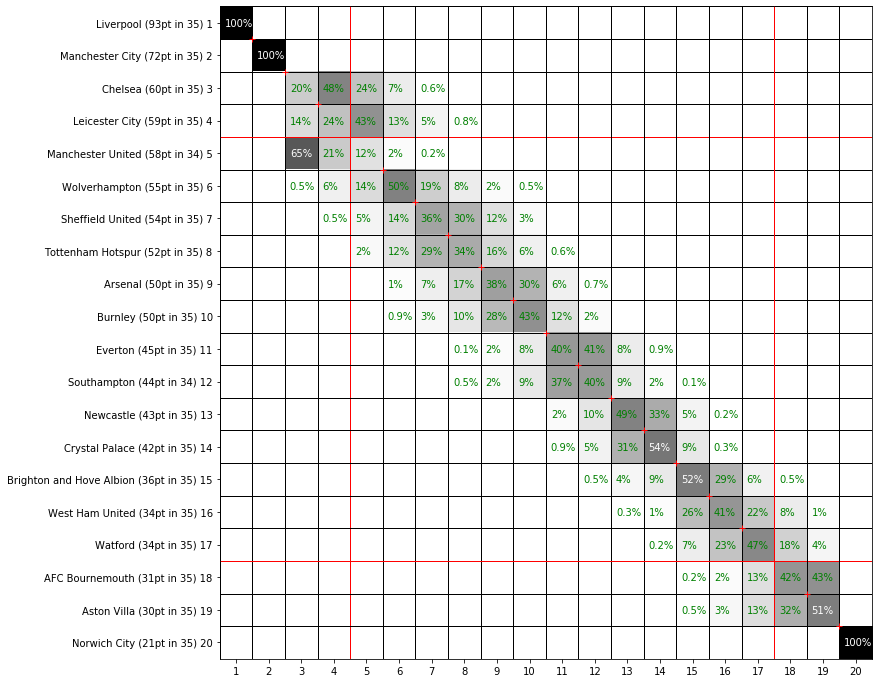

In [8]:
season.probability_grid(ind=ind);

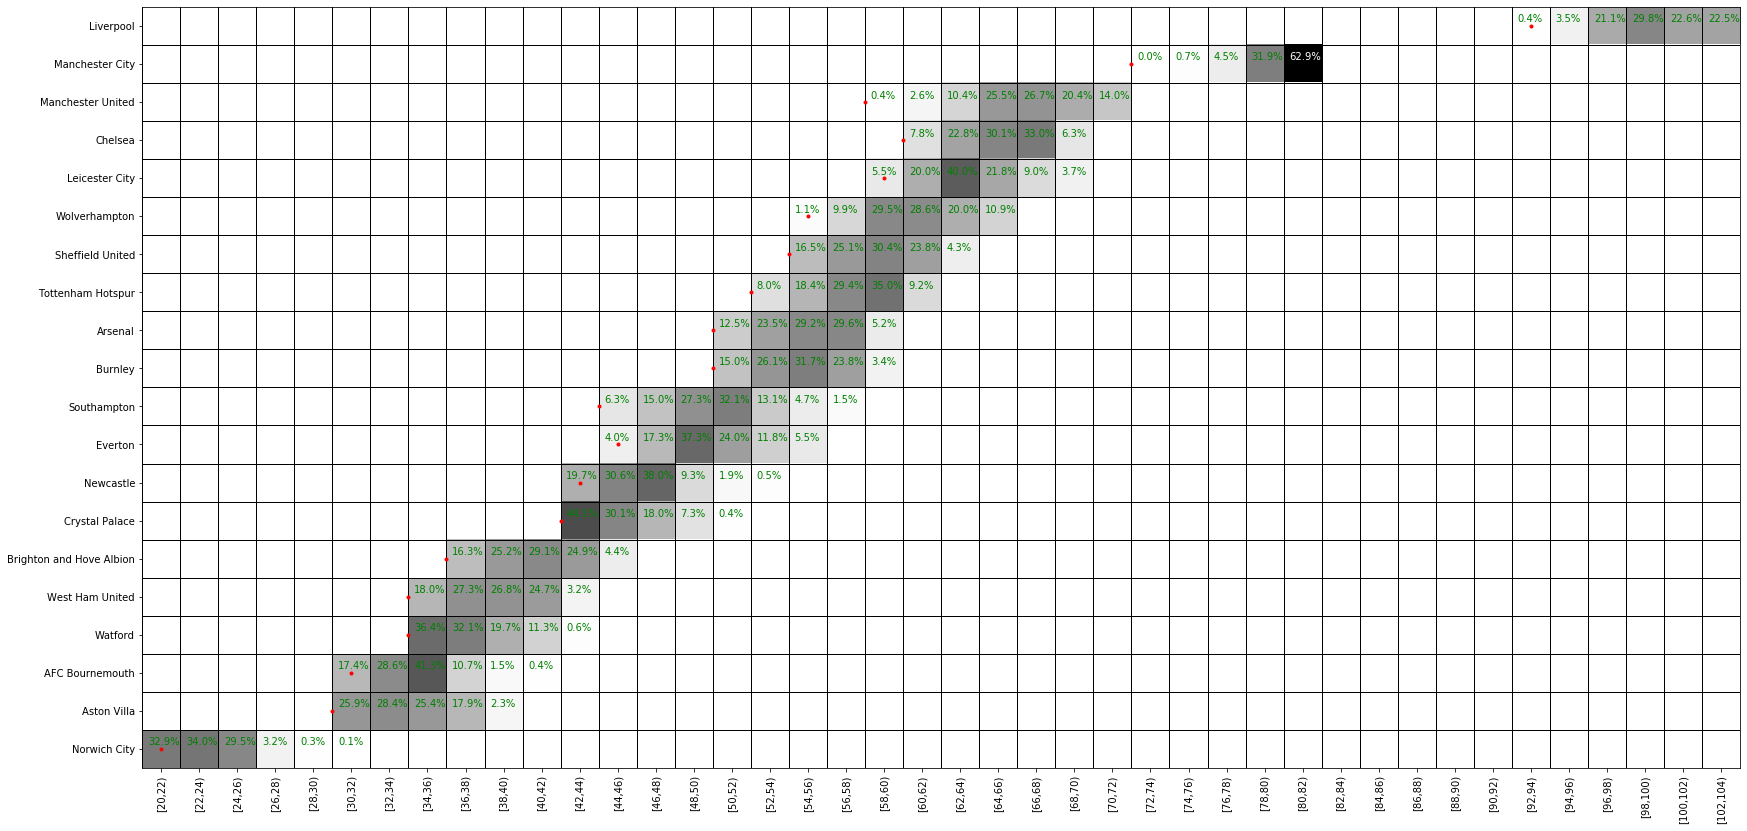

In [9]:
season.points_probability_grid(ind=ind);

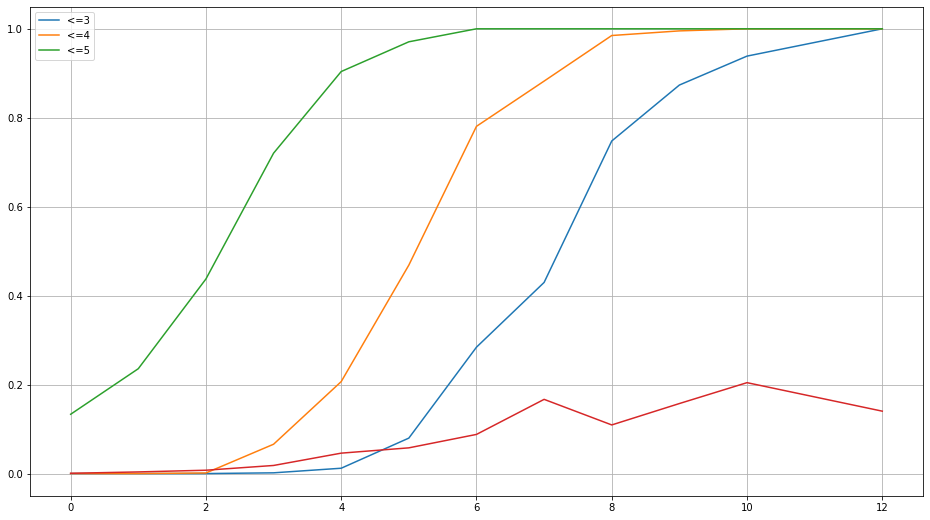

In [10]:

def plot_place_per_points(team_name,lgh):
    p0=lgh.current_points[team_name]

    i=lgh.team_id[team_name]

    #p0=league.current_points['Wolverhampton']
    #i = league.team_id['Wolverhampton']

    P=(lgh.points_per_team[i,:]-p0).astype(int)
    pp=np.unique(P)

    prob4=[]
    prob3=[]
    prob5=[]
    probp=[]
    for p in pp:
        ind =( P==p)
        probp.append(ind.sum()/ind.size)
        prob4.append(np.sum(lgh.place_per_team[i,ind]<=4)/ind.sum())
        prob3.append(np.sum(lgh.place_per_team[i,ind]<=3)/ind.sum())
        prob5.append(np.sum(lgh.place_per_team[i,ind]<=5)/ind.sum())

    C = len([x for x in lgh.matches_to_sim if team_name in [x.home_team.name,x.away_team.name]])
    C=1
    plt.figure(figsize=(16,9))
    plt.plot(pp/C,prob3,label='<=3')
    plt.plot(pp/C,prob4,label='<=4')
    plt.plot(pp/C,prob5,label='<=5')
    plt.plot(pp/C,probp)
    plt.grid(True)
    plt.legend()
plot_place_per_points(season.teams['Manchester United'].name,season)
#plot_place_per_points(league.teams['Wolverhampton'].name,league)

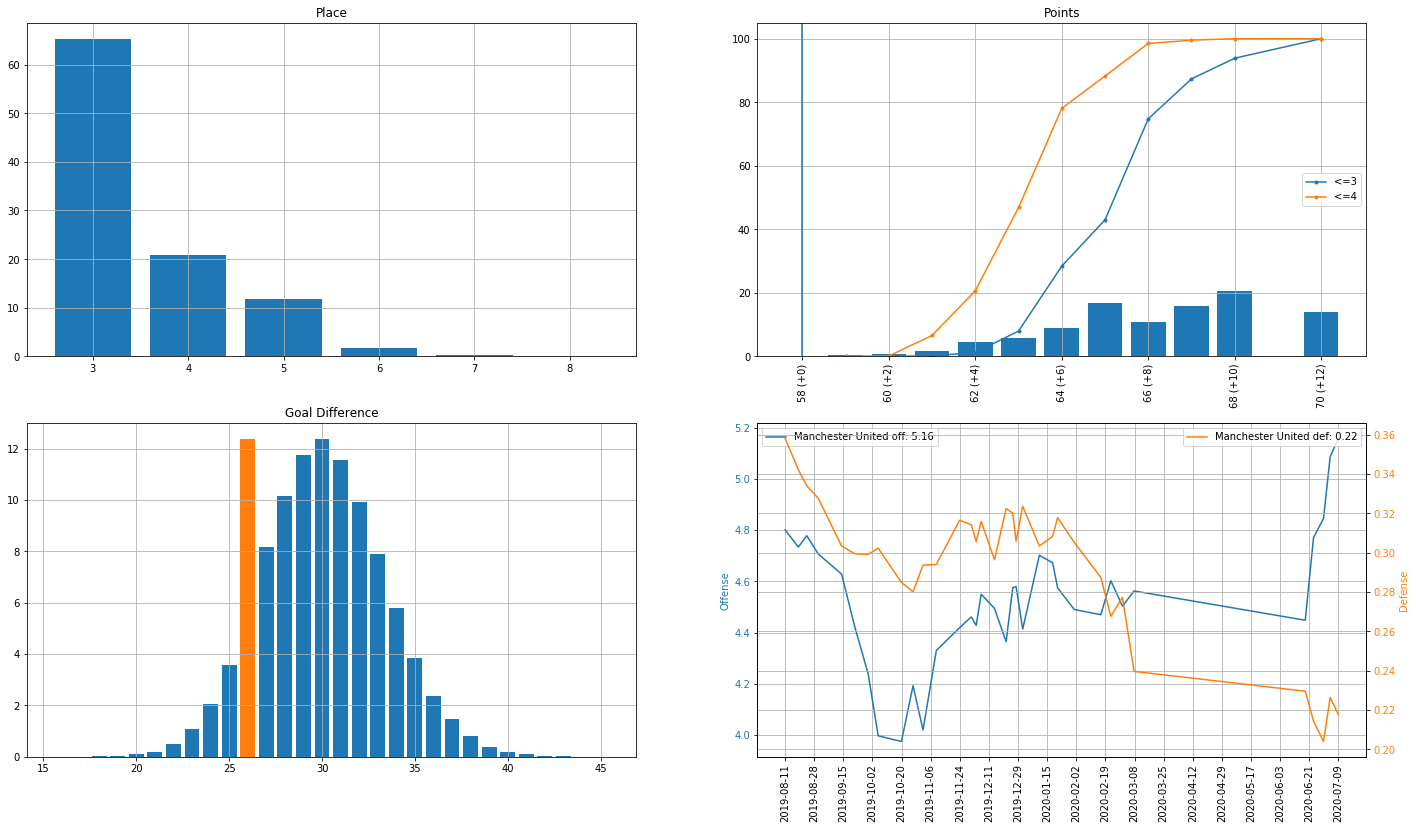

In [11]:
my_team = season.teams['Manchester United']

names = []
importance = []
for m in season.matches_to_sim:
    p=season.what_if(m,ref_team=my_team,place=4,or_better=True,show_plot=False)[0]
    names.append(m.id)
    importance.append(np.sum((p[1:]-p[0])**2))

names=np.array(names)
importance=np.array(importance)

isort = np.argsort(-importance)
names=names[isort]
importance=importance[isort]
season.team_report(my_team)

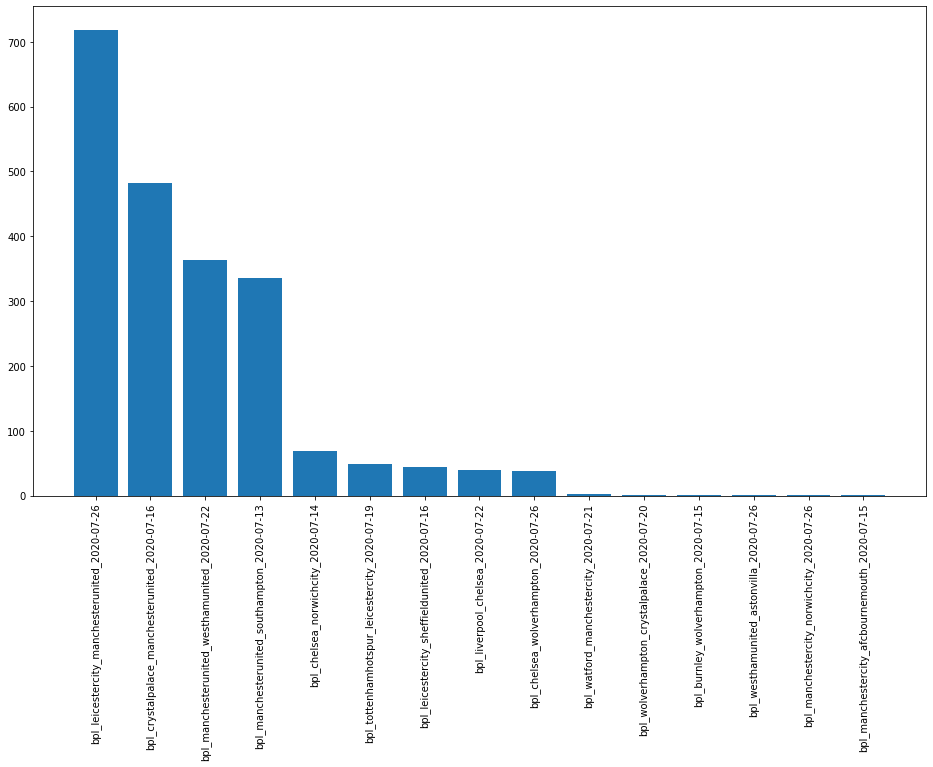

In [12]:
n_plot=15

plt.figure(figsize=(16,9))
plt.bar(np.arange(n_plot),importance[:n_plot])
plt.xticks(np.arange(n_plot),names[:n_plot],rotation=90);

(array([86.276     , 93.42995979, 70.87428279, 79.41629617]),
 <Figure size 1152x648 with 1 Axes>)

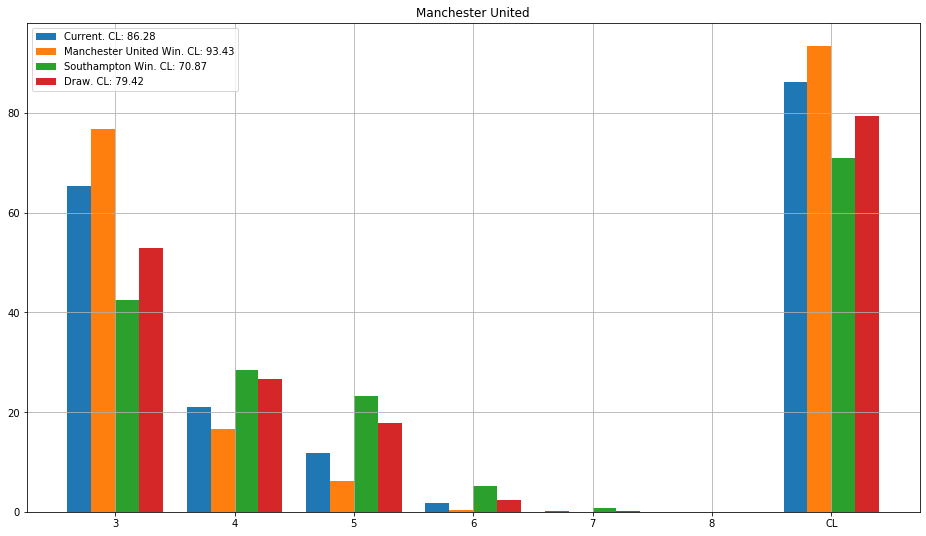

In [13]:
match = season.matches_to_sim[season.match_id['bpl_manchesterunited_southampton_2020-07-13']]
my_team=season.teams['Manchester United']
season.what_if(match,ref_team=my_team,place=4,or_better=True)

D:\Miniconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


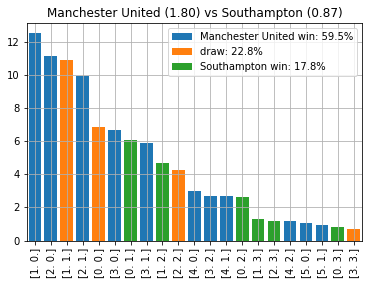

In [14]:
match.home_team.outcomes_vs(match.away_team)

In [15]:
season.matches_remaining(team_filter=['Manchester U','Leic','Chel'])

,Date,Home,Away,Home Wins,Draw,Away Wins,av HG,av AG
0,2020-07-13,Manchester United,Southampton,59.7,22.7,17.6,1.8,0.9
1,2020-07-14,Chelsea,Norwich City,72.9,16.5,10.6,2.4,0.8
2,2020-07-16,Crystal Palace,Manchester United,10.9,19.8,69.4,0.6,2.0
3,2020-07-16,Leicester City,Sheffield United,41.3,28.1,30.6,1.3,1.1
4,2020-07-19,Tottenham Hotspur,Leicester City,32.9,25.9,41.2,1.2,1.4
5,2020-07-22,Liverpool,Chelsea,51.8,21.9,26.3,1.9,1.3
6,2020-07-22,Manchester United,West Ham United,63.4,20.5,16.2,2.0,0.9
7,2020-07-26,Chelsea,Wolverhampton,33.2,28.9,38.0,1.1,1.2
8,2020-07-26,Leicester City,Manchester United,21.5,24.8,53.7,0.9,1.6


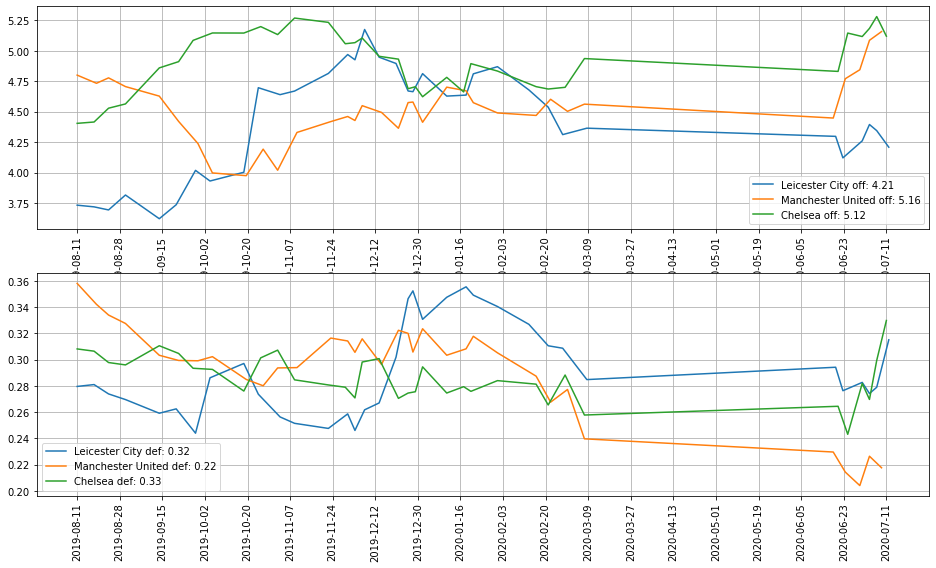

In [16]:
ax=None
for team in calib.teams.values():
    if team.name in ['Manchester United','Leicester City','Chelsea']:
    #if team.name in ['BPLHome','BPLAway']:
        ax=team.plt(ax=ax)
        #ax[0].axvline(x=37)
        #ax[1].axvline(x=37)


In [17]:
df=pd.read_csv('https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv')
df=df.set_index('name')
df = df.join(sr).reset_index()[['name','off','def','Off','Deff']].dropna()
df.head(10)

,name,off,def,Off,Deff
0,Manchester City,3.32,0.20,7.29,0.19
2,Liverpool,2.78,0.31,5.88,0.26
6,Manchester United,2.50,0.33,5.16,0.22
9,Chelsea,2.51,0.59,5.12,0.33
13,Wolverhampton,1.94,0.34,3.53,0.21
17,Leicester City,2.13,0.53,4.21,0.32
20,Arsenal,2.11,0.60,4.08,0.31
25,Tottenham Hotspur,2.09,0.67,3.89,0.33
30,Everton,1.92,0.65,3.42,0.35
36,Sheffield United,1.77,0.59,3.34,0.30


array([ 2.67301653, -1.53855849])

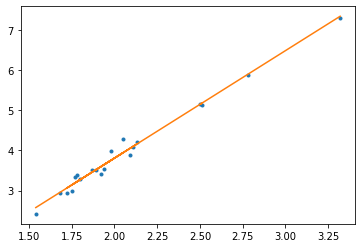

In [18]:
plt.plot(df['off'],df['Off'],'.')
poly = np.polyfit(df['off'],df['Off'],1)
plt.plot(df['off'],np.polyval(poly,df['off']))
poly

array([0.29517301, 0.14045407])

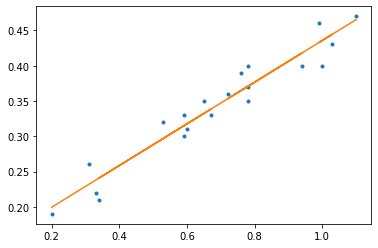

In [19]:
plt.plot(df['def'],df['Deff'],'.')
poly = np.polyfit(df['def'],df['Deff'],1)
plt.plot(df['def'],np.polyval(poly,df['def']))
poly

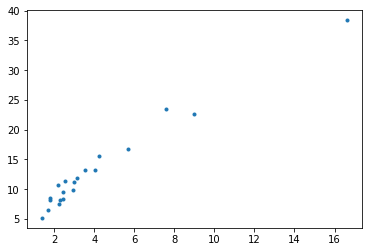

In [20]:
plt.plot(df['off']/df['def'],df['Off']/df['Deff'],'.')